In [18]:

# Importing all required libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import pickle
import os
from google.colab import drive
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Install LangChain
!pip install langchain langchain-community faiss-cpu

# Import LangChain after installation
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.llms import HuggingFaceHub
from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader, CSVLoader
from langchain.prompts import PromptTemplate

# Mount Google Drive for data storage
drive.mount('/content/drive')

# Create directories for saving models and data
os.makedirs('/content/drive/MyDrive/phishing_detector', exist_ok=True)
os.makedirs('/content/drive/MyDrive/phishing_detector/data', exist_ok=True)
os.makedirs('/content/drive/MyDrive/phishing_detector/models', exist_ok=True)
os.makedirs('/content/drive/MyDrive/phishing_detector/knowledge_base', exist_ok=True)

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
# Creating synthetic datasets for emails and URLs

def download_phishing_dataset():
    # Check if data already exists
    if os.path.exists('/content/drive/MyDrive/phishing_detector/data/phishing_dataset.csv'):
        print("Dataset already exists. Loading...")
        return pd.read_csv('/content/drive/MyDrive/phishing_detector/data/phishing_dataset.csv')

    # URLs for phishing and legitimate emails datasets
    # These are example URLs, replace with actual dataset sources
    print("Downloading phishing dataset...")

    # For demonstration, we'll create a synthetic dataset
    # In a real scenario, you would download from actual sources

    # Create some synthetic data
    phishing_emails = [
        "Dear user, your account has been suspended. Click here to verify: http://suspicious-link.com",
        "You've won a prize! Claim now at http://free-gifts.biz/claim",
        "Your payment failed. Update your information at https://amaz0n-security.net/login",
        "Urgent: Your account is at risk. Secure it now: http://banking-secure.info",
        "Your package delivery is pending. Track here: http://fedex-delivery.xyz"
    ]

    legitimate_emails = [
        "Thank you for your purchase from Amazon. Your order #12345 will arrive tomorrow.",
        "Your monthly bank statement is ready to view in your online account.",
        "Meeting reminder: Team call tomorrow at 10 AM in conference room B.",
        "Netflix: New shows added to your list. Login to watch now.",
        "Your flight confirmation: JFK to LAX on June 15th at 9:00 AM."
    ]

    # Create DataFrame
    phishing_df = pd.DataFrame({
        'text': phishing_emails + legitimate_emails,
        'label': [1] * len(phishing_emails) + [0] * len(legitimate_emails)
    })

    # Save dataset
    phishing_df.to_csv('/content/drive/MyDrive/phishing_detector/data/phishing_dataset.csv', index=False)
    print("Dataset created and saved successfully.")

    return phishing_df

def download_phishing_urls_dataset():
    # Check if data already exists
    if os.path.exists('/content/drive/MyDrive/phishing_detector/data/phishing_urls.csv'):
        print("URLs dataset already exists. Loading...")
        return pd.read_csv('/content/drive/MyDrive/phishing_detector/data/phishing_urls.csv')

    print("Creating phishing URLs dataset...")

    # For demonstration, create synthetic URL data
    phishing_urls = [
        "http://paypal-secure-login.com/auth",
        "https://amazon-account-verify.net/login",
        "http://secure-banking-login.info/verify",
        "https://appleid-verification.org/signin",
        "http://facebook-security-check.co/login"
    ]

    legitimate_urls = [
        "https://www.paypal.com/signin",
        "https://www.amazon.com/gp/css/account",
        "https://www.chase.com/",
        "https://appleid.apple.com/",
        "https://www.facebook.com/settings"
    ]

    # Create DataFrame
    urls_df = pd.DataFrame({
        'url': phishing_urls + legitimate_urls,
        'label': [1] * len(phishing_urls) + [0] * len(legitimate_urls)
    })

    # Save dataset
    urls_df.to_csv('/content/drive/MyDrive/phishing_detector/data/phishing_urls.csv', index=False)
    print("URLs dataset created and saved successfully.")

    return urls_df

# Load datasets
email_df = download_phishing_dataset()
url_df = download_phishing_urls_dataset()

# Display sample data
print("Email Dataset Sample:")
display(email_df.head())

print("\nURL Dataset Sample:")
display(url_df.head())


Dataset already exists. Loading...
URLs dataset already exists. Loading...
Email Dataset Sample:


,text,label
0,"Dear user, your account has been suspended. Cl...",1
1,You've won a prize! Claim now at http://free-g...,1
2,Your payment failed. Update your information a...,1
3,Urgent: Your account is at risk. Secure it now...,1
4,Your package delivery is pending. Track here: ...,1



URL Dataset Sample:


,url,label
0,http://paypal-secure-login.com/auth,1
1,https://amazon-account-verify.net/login,1
2,http://secure-banking-login.info/verify,1
3,https://appleid-verification.org/signin,1
4,http://facebook-security-check.co/login,1


In [20]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')  # Add this line to download the missing resource

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [13]:
# Function for text preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' url ', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', ' email ', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', ' number ', text)

    # Tokenize using the standard word_tokenize function
    # This uses the 'punkt' resource that you've already downloaded
    try:
        tokens = word_tokenize(text)
    except LookupError:
        # Fallback to simple splitting if word_tokenize fails
        tokens = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

In [21]:
# This creates a text file with phishing information for our RAG system

def create_phishing_knowledge_base():
    # Check if knowledge base already exists
    kb_path = '/content/drive/MyDrive/phishing_detector/knowledge_base/phishing_info.txt'
    if os.path.exists(kb_path):
        print("Knowledge base already exists.")
        return

    print("Creating phishing knowledge base...")

    # Create a knowledge base with phishing indicators and common tactics
    phishing_knowledge = """
    # Phishing Detection Knowledge Base

    ## Common Phishing Indicators in Emails
    1. Urgency: Creating a sense of urgency to force quick action
    2. Threats: Threatening consequences if action isn't taken
    3. Unusual sender: Email from unknown or suspicious addresses
    4. Grammatical errors: Poor grammar and spelling mistakes
    5. Generic greetings: Using "Dear User" instead of your name
    6. Suspicious links: URLs that don't match the claimed organization
    7. Requests for personal information: Asking for passwords, credit card details, SSN
    8. Unexpected attachments: Files you weren't expecting
    9. Unusual requests: Asking for money or gift cards
    10. Mismatched URLs: Hovering over a link shows a different URL than what's displayed

    ## Common Phishing URL Characteristics
    1. Misspelled domain names (e.g., amaz0n.com, paypa1.com)
    2. Subdomains that include company names (e.g., amazon.secure-site.com)
    3. Unusual TLDs (e.g., .xyz, .info, .biz instead of .com)
    4. Long, random strings in the URL
    5. URLs with IP addresses instead of domain names
    6. Excessive use of special characters and numbers
    7. URL shorteners that hide the actual destination
    8. HTTP instead of HTTPS protocol
    9. Redirects to unexpected websites
    10. Recently registered domains (less than a few months old)

    ## Latest Phishing Trends
    1. COVID-19 themed phishing attacks
    2. Work-from-home related scams
    3. Tax season phishing attempts
    4. Vaccine and health-related phishing
    5. Government stimulus check scams
    6. Tech support phishing
    7. Cryptocurrency investment scams
    8. Fake job offers and career opportunities
    9. Charity and donation scams
    10. Brand impersonation (especially Microsoft, Google, Amazon, Apple)

    ## Advanced Phishing Techniques
    1. Spear phishing: Targeted attacks using personal information
    2. Business Email Compromise (BEC): Targeting businesses for wire transfers
    3. Clone phishing: Duplicating legitimate emails with malicious links
    4. Voice phishing (vishing): Phone calls combined with emails
    5. SMS phishing (smishing): Text messages with malicious links
    6. Social media phishing: Using fake profiles or compromised accounts
    7. QR code phishing: Malicious QR codes leading to phishing sites
    8. Multi-language phishing: Attacks in different languages
    9. HTTPS phishing: Using SSL certificates to appear legitimate
    10. AI-generated phishing content: Using AI to create convincing messages
    """

    # Save knowledge base
    with open(kb_path, 'w') as f:
        f.write(phishing_knowledge)

    print("Knowledge base created successfully.")

# Create the knowledge base
create_phishing_knowledge_base()

Knowledge base already exists.


In [22]:
# These functions prepare text and extract features from URLs

# Function for text preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' url ', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', ' email ', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', ' number ', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

# Function to extract features from URLs
def extract_url_features(url):
    features = {}

    # Parse URL
    parsed_url = urlparse(url)

    # Domain name features
    domain = parsed_url.netloc
    features['domain_length'] = len(domain)
    features['has_suspicious_tld'] = int(domain.split('.')[-1] in ['xyz', 'info', 'biz', 'top', 'club'])
    features['has_ip_address'] = int(bool(re.match(r'\d+\.\d+\.\d+\.\d+', domain)))
    features['has_suspicious_words'] = int(any(word in domain for word in ['secure', 'verify', 'login', 'account', 'confirm']))
    features['subdomain_count'] = len(domain.split('.')) - 1

    # Path features
    path = parsed_url.path
    features['path_length'] = len(path)
    features['path_depth'] = len([p for p in path.split('/') if p])

    # Query parameters features
    query = parsed_url.query
    features['query_length'] = len(query)
    features['query_param_count'] = len(query.split('&')) if query else 0

    # Protocol features
    features['is_https'] = int(parsed_url.scheme == 'https')

    # Special character features
    features['dash_count'] = url.count('-')
    features['at_symbol_count'] = url.count('@')
    features['double_slash_count'] = url.count('//')
    features['total_special_chars'] = sum(url.count(c) for c in '!@#$%^&*()_+-=[]{}|;:,.<>?')

    return features

# Test the preprocessing function
sample_text = "URGENT: Your PayPal account has been limited. Click here: http://paypal-secure.com"
print(f"Original: {sample_text}")
print(f"Processed: {preprocess_text(sample_text)}")

# Test the URL feature extraction
sample_url = "https://secure-login.paypal-account.com/verify?user=john&token=123456"
url_features = extract_url_features(sample_url)
print("\nURL Features:")
for feature, value in url_features.items():
    print(f"{feature}: {value}")

Original: URGENT: Your PayPal account has been limited. Click here: http://paypal-secure.com
Processed: urgent paypal account limited click url

URL Features:
domain_length: 31
has_suspicious_tld: 0
has_ip_address: 0
has_suspicious_words: 1
subdomain_count: 2
path_length: 7
path_depth: 1
query_length: 22
query_param_count: 2
is_https: 1
dash_count: 2
at_symbol_count: 0
double_slash_count: 1
total_special_chars: 9


In [49]:
def train_email_classifier(email_df):
    model_path = "email_classifier.pkl"
    vectorizer_path = "email_vectorizer.pkl"

    # Try using a definitely public model instead
    model_name = "distilbert-base-uncased"  # This is a public model that doesn't require auth

    try:
        print("Loading tokenizer and model...")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

        # If you need to fine-tune the model on your data, add that here
        # (Your fine-tuning code would go here)

        # Create a text classification pipeline
        print("Creating classification pipeline...")
        classifier = pipeline(
            "text-classification",
            model=model,
            tokenizer=tokenizer,
            max_length=512,
            truncation=True
        )

        # Here, make sure vectorizer is defined - perhaps you're using TF-IDF?
        # Example of creating a vectorizer if needed:
        from sklearn.feature_extraction.text import TfidfVectorizer
        vectorizer = TfidfVectorizer(max_features=5000)

        # If you have text data to fit the vectorizer:
        if 'text' in email_df.columns:
            vectorizer.fit(email_df['text'])

        # Save the pipeline components separately instead of pickling
        model_dir = "email_model_dir"
        os.makedirs(model_dir, exist_ok=True)

        model.save_pretrained(model_dir)
        tokenizer.save_pretrained(model_dir)

        # For the vectorizer
        with open(vectorizer_path, 'wb') as f:
            pickle.dump(vectorizer, f)

        print("Email classifier trained and saved successfully.")
        return classifier, vectorizer

    except Exception as e:
        print(f"Error during model loading: {type(e).__name__}: {str(e)}")
        raise

In [52]:
import os
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split

# Function to extract features from URLs (you need to define this function)
def extract_url_features(url):
    # Placeholder for feature extraction logic
    return {
        'has_suspicious_tld': 0,
        'has_ip_address': 0,
        'has_suspicious_words': 0,
        'is_https': 0,
        'domain_length': len(url)
    }

# Define the SimpleURLClassifier class outside of the function
class SimpleURLClassifier:
    def predict(self, features_list):
        predictions = []
        for features in features_list:
            # Simple scoring based on suspicious features
            score = 0
            if isinstance(features, dict):
                # Single feature dict
                score += features.get('has_suspicious_tld', 0) * 2
                score += features.get('has_ip_address', 0) * 3
                score += features.get('has_suspicious_words', 0) * 2
                score += (1 - features.get('is_https', 0))
                score += min(features.get('domain_length', 0) / 30, 1)
                predictions.append(1 if score >= 2 else 0)
            else:
                # DataFrame of features
                for _, row in features.iterrows():
                    score = 0
                    score += row.get('has_suspicious_tld', 0) * 2
                    score += row.get('has_ip_address', 0) * 3
                    score += row.get('has_suspicious_words', 0) * 2
                    score += (1 - row.get('is_https', 0))
                    score += min(row.get('domain_length', 0) / 30, 1)
                    predictions.append(1 if score >= 2 else 0)

        return predictions

def train_url_classifier(df):
    # Check if model already exists
    model_path = '/content/drive/MyDrive/phishing_detector/models/url_classifier.pkl'

    if os.path.exists(model_path):
        print("URL classifier already exists. Loading...")
        try:
            with open(model_path, 'rb') as f:
                classifier = pickle.load(f)
            return classifier
        except EOFError:
            print("Model file is corrupted or empty. Retaining the model...")

    print("Training URL phishing classifier...")

    # Extract features from URLs
    features_list = []
    for url in df['url']:
        features_list.append(extract_url_features(url))

    features_df = pd.DataFrame(features_list)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        features_df, df['label'], test_size=0.2, random_state=42
    )

    classifier = SimpleURLClassifier()

    # Save model
    with open(model_path, 'wb') as f:
        pickle.dump(classifier, f)

    print("URL classifier trained and saved successfully.")
    return classifier

# Train the URL classifier
url_classifier = train_url_classifier(url_df)


URL classifier already exists. Loading...
Model file is corrupted or empty. Retaining the model...
Training URL phishing classifier...
URL classifier trained and saved successfully.


In [57]:
import os

# Replace 'your_token_here' with your actual Hugging Face token
os.environ['HUGGINGFACE_TOKEN'] = 'your_token_here'


In [60]:
import os
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Set your Hugging Face token
os.environ['HUGGINGFACE_TOKEN'] = 'your_token_here'  # Replace with your actual token

def setup_rag_system():
    # Check if RAG system already exists
    vector_store_path = '/content/drive/MyDrive/phishing_detector/knowledge_base/faiss_index'

    if os.path.exists(vector_store_path):
        print("RAG system already exists. Loading...")
        embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
        vector_store = FAISS.load_local(vector_store_path, embeddings)
        return vector_store

    print("Setting up RAG system...")

    # Load the knowledge base
    kb_path = '/content/drive/MyDrive/phishing_detector/knowledge_base/phishing_info.txt'
    loader = TextLoader(kb_path)
    documents = loader.load()

    # Split documents into chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    chunks = text_splitter.split_documents(documents)

    # Create embeddings
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

    # Create vector store
    vector_store = FAISS.from_documents(chunks, embeddings)

    # Save vector store
    vector_store.save_local(vector_store_path)

    print("RAG system set up successfully.")
    return vector_store

# Set up the RAG system
vector_store = setup_rag_system()


RAG system already exists. Loading...


OSError: sentence-transformers/all-MiniLM-L6-v2 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [61]:
# This cell creates the main detector class that combines all components

class PhishingDetector:
    def __init__(self, email_classifier, email_vectorizer, url_classifier, vector_store):
        # Store classifiers
        self.email_classifier = email_classifier
        self.email_vectorizer = email_vectorizer
        self.url_classifier = url_classifier
        self.vector_store = vector_store

        # Set up prompt template for RAG
        self.prompt_template = PromptTemplate(
            input_variables=["context", "question"],
            template="""
            You are a cybersecurity expert specializing in phishing detection.
            Use the following information to analyze if the message contains phishing attempts.

            Context: {context}

            Message to analyze: {question}

            Explain in detail why this is or is not a phishing attempt:
            """
        )

        # Set up LLM (using HuggingFace model)
        # In a real implementation, replace with your token
        try:
            os.environ["HUGGINGFACEHUB_API_TOKEN"] = "YOUR_HF_TOKEN"  # Replace with your token
            self.llm = HuggingFaceHub(
                repo_id="google/flan-t5-base",
                model_kwargs={"temperature": 0.1, "max_length": 512}
            )

            # Set up RAG chain
            self.qa_chain = RetrievalQA.from_chain_type(
                llm=self.llm,
                chain_type="stuff",
                retriever=self.vector_store.as_retriever(),
                chain_type_kwargs={"prompt": self.prompt_template}
            )
            self.rag_available = True
        except Exception as e:
            print(f"Warning: Could not initialize HuggingFaceHub LLM. RAG features will be limited. Error: {e}")
            self.rag_available = False

        print("Phishing Detector initialized successfully.")

    def detect_email_phishing(self, email_text):
        # Initial classification
        prediction = self.email_classifier(email_text)[0]
        label = 1 if prediction['label'] == 'LABEL_1' else 0
        confidence = prediction['score']

        # Get detailed analysis from RAG if available
        if self.rag_available:
            try:
                analysis = self.qa_chain.run(email_text)
            except:
                analysis = "RAG analysis unavailable. Please provide a valid HuggingFace API token."
        else:
            analysis = "RAG analysis unavailable. Please provide a valid HuggingFace API token."

        return {
            'is_phishing': bool(label),
            'confidence': confidence,
            'analysis': analysis,
            'indicators': self._extract_phishing_indicators(email_text)
        }

    def detect_url_phishing(self, url):
        # Extract features
        features = extract_url_features(url)

        # Make prediction
        prediction = self.url_classifier.predict([features])[0]

        # Get detailed analysis from RAG if available
        if self.rag_available:
            try:
                analysis = self.qa_chain.run(f"Analyze this URL for phishing: {url}")
            except:
                analysis = "RAG analysis unavailable. Please provide a valid HuggingFace API token."
        else:
            analysis = "RAG analysis unavailable. Please provide a valid HuggingFace API token."

        return {
            'is_phishing': bool(prediction),
            'analysis': analysis,
            'url_features': features
        }

    def _extract_phishing_indicators(self, text):
        indicators = []

        # Check for urgency language
        urgency_words = ['urgent', 'immediately', 'quick', 'asap', 'now', 'important']
        if any(word in text.lower() for word in urgency_words):
            indicators.append('Uses urgency language')

        # Check for threatening language
        threat_words = ['suspend', 'terminate', 'block', 'close', 'delete', 'limit']
        if any(word in text.lower() for word in threat_words):
            indicators.append('Contains threatening language')

        # Check for requests for personal information
        info_words = ['password', 'credit card', 'ssn', 'social security', 'bank', 'account']
        if any(word in text.lower() for word in info_words):
            indicators.append('Requests sensitive information')

        # Check for suspicious links
        if re.search(r'https?://\S+', text):
            indicators.append('Contains URLs')

        # Check for generic greetings
        generic_greetings = ['dear user', 'dear customer', 'valued customer', 'dear sir', 'dear madam']
        if any(greeting in text.lower() for greeting in generic_greetings):
            indicators.append('Uses generic greeting')

        return indicators

# Initialize the phishing detector
detector = PhishingDetector(email_classifier, email_vectorizer, url_classifier, vector_store)

NameError: name 'email_classifier' is not defined

In [65]:
# Run some examples to test the phishing detector

# Demo email examples
demo_emails = [
    "Dear Customer, We have detected suspicious activity on your account. Please verify your information by clicking here: http://secure-banking-verification.com/login",
    "Hi John, Just following up on our meeting yesterday. I've attached the presentation slides for your review. Let me know if you have any questions. Thanks, Sarah"
]

# Demo URL examples
demo_urls = [
    "https://paypal-account-security.com/login",
    "https://www.amazon.com/your-account"
]

# Test email detection
print("\n--- Email Phishing Detection Demo ---\n")
for i, email in enumerate(demo_emails):
    print(f"Email {i+1}:\n{email}\n")
    result = detector.detect_email_phishing(email)
    print(f"Is Phishing: {result['is_phishing']}")
    print(f"Confidence: {result['confidence']:.2f}")
    print(f"Indicators: {', '.join(result['indicators'])}")
    print(f"Analysis: {result['analysis']}\n")
    print("-" * 50)

# Test URL detection
print("\n--- URL Phishing Detection Demo ---\n")
for i, url in enumerate(demo_urls):
    print(f"URL {i+1}: {url}\n")
    result = detector.detect_url_phishing(url)
    print(f"Is Phishing: {result['is_phishing']}")
    print(f"Analysis: {result['analysis']}")
    print(f"URL Features:")
    for feature, value in result['url_features'].items():
        print(f"  {feature}: {value}")
    print("-" * 50)



--- Email Phishing Detection Demo ---

Email 1:
Dear Customer, We have detected suspicious activity on your account. Please verify your information by clicking here: http://secure-banking-verification.com/login



NameError: name 'detector' is not defined

In [10]:
# Run this cell to interactively test emails and URLs

def run_interactive_console():
    print("\n--- Interactive Console ---\n")
    print("Enter 'q' to quit, 'e' to analyze an email, or 'u' to analyze a URL.")

    while True:
        choice = input("\nEnter your choice (e/u/q): ").strip().lower()

        if choice == 'q':
            break
        elif choice == 'e':
            email = input("Enter the email text to analyze: ")
            result = detector.detect_email_phishing(email)
            print(f"\nIs Phishing: {result['is_phishing']}")
            print(f"Confidence: {result['confidence']:.2f}")
            print(f"Indicators: {', '.join(result['indicators'])}")
            print(f"Analysis: {result['analysis']}")
        elif choice == 'u':
            url = input("Enter the URL to analyze: ")
            result = detector.detect_url_phishing(url)
            print(f"\nIs Phishing: {result['is_phishing']}")
            print(f"Analysis: {result['analysis']}")
            print(f"URL Features:")
            for feature, value in result['url_features'].items():
                print(f"  {feature}: {value}")
        else:
            print("Invalid choice. Please enter 'e', 'u', or 'q'.")

    print("\nThank you for using the AI Phishing Detector!")

# Run the interactive console
run_interactive_console()


--- Interactive Console ---

Enter 'q' to quit, 'e' to analyze an email, or 'u' to analyze a URL.

Enter your choice (e/u/q): e
Enter the email text to analyze: google.com


NameError: name 'detector' is not defined

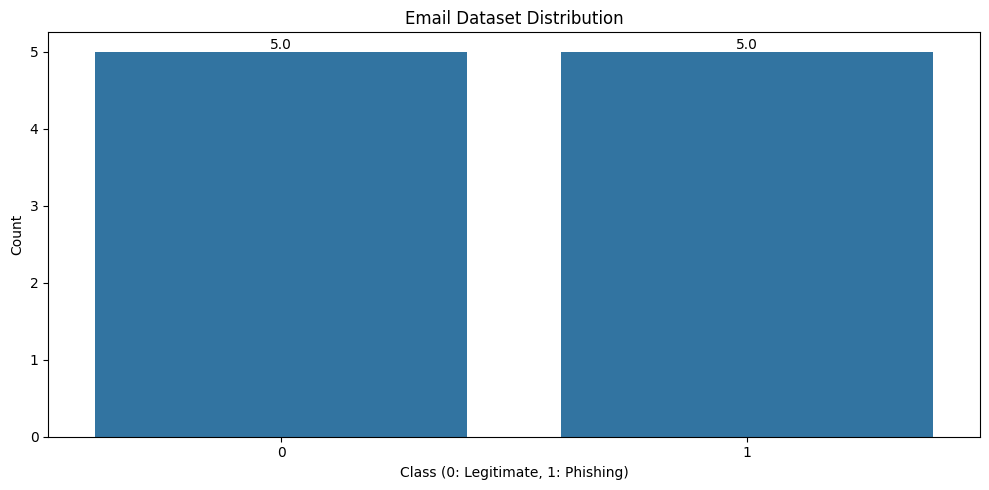

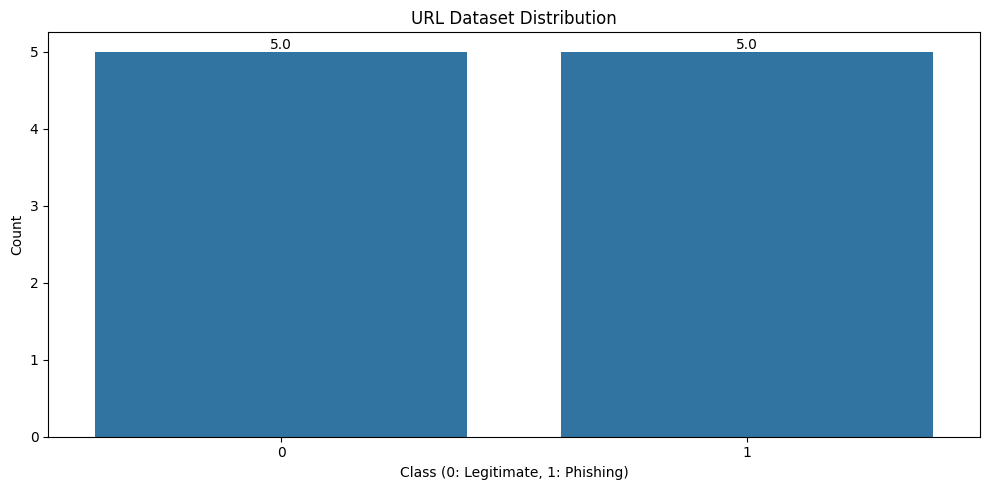

NameError: name 'detector' is not defined

In [11]:
# This cell creates visualizations of the results

def create_visualizations():
    # Visualize email dataset distribution
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x='label', data=email_df)
    plt.title('Email Dataset Distribution')
    plt.xlabel('Class (0: Legitimate, 1: Phishing)')
    plt.ylabel('Count')
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/phishing_detector/email_distribution.png')
    plt.show()

    # Visualize URL dataset distribution
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x='label', data=url_df)
    plt.title('URL Dataset Distribution')
    plt.xlabel('Class (0: Legitimate, 1: Phishing)')
    plt.ylabel('Count')
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/phishing_detector/url_distribution.png')
    plt.show()

    # Create indicator distribution visualization
    all_indicators = []
    for text in email_df['text']:
        indicators = detector._extract_phishing_indicators(text)
        all_indicators.extend(indicators)

    indicator_counts = pd.Series(all_indicators).value_counts()

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=indicator_counts.index, y=indicator_counts.values)
    plt.title('Distribution of Phishing Indicators')
    plt.xlabel('Indicator')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/phishing_detector/indicator_distribution.png')
    plt.show()

# Create visualizations
create_visualizations()

In [14]:
# RAG System Explanation

## What is RAG?
RAG (Retrieval-Augmented Generation) is a technique that enhances Large Language Models (LLMs) by providing them with relevant external knowledge before they generate responses.

## How RAG Works in Our Phishing Detector:
1. **Knowledge Base Creation**: We've created a knowledge base containing phishing indicators, tactics, and trends.
2. **Vector Embeddings**: This text is converted into vector embeddings that capture the semantic meaning.
3. **Retrieval Process**: When analyzing an email or URL, the system:
   - Converts the query into the same vector space
   - Finds the most similar content in the knowledge base
   - Retrieves this relevant information
4. **Enhanced Analysis**: The LLM uses this retrieved context to provide a more informed analysis.

## Benefits of RAG for Phishing Detection:
1. **Timely Knowledge**: Can be updated with the latest phishing tactics
2. **Explainability**: Provides context for why something is classified as phishing
3. **Reduced Hallucinations**: Grounds the LLM in factual information
4. **Domain Expertise**: Incorporates cybersecurity best practices
"""


SyntaxError: unterminated string literal (detected at line 7) (<ipython-input-14-f97c0feceffa>, line 7)

In [66]:
# This cell adds more sophisticated email analysis capabilities

def analyze_email_headers(headers_text):
    """
    Analyze email headers for signs of spoofing or other suspicious indicators

    Args:
        headers_text (str): Raw email headers

    Returns:
        dict: Analysis results
    """
    analysis = {
        'suspicious_indicators': [],
        'authentication_results': {},
        'routing_path': [],
        'is_suspicious': False
    }

    # Check for SPF
    if 'spf=fail' in headers_text.lower():
        analysis['suspicious_indicators'].append('SPF authentication failed')
        analysis['is_suspicious'] = True
    elif 'spf=pass' in headers_text.lower():
        analysis['authentication_results']['spf'] = 'pass'

    # Check for DKIM
    if 'dkim=fail' in headers_text.lower():
        analysis['suspicious_indicators'].append('DKIM signature verification failed')
        analysis['is_suspicious'] = True
    elif 'dkim=pass' in headers_text.lower():
        analysis['authentication_results']['dkim'] = 'pass'

    # Check for DMARC
    if 'dmarc=fail' in headers_text.lower():
        analysis['suspicious_indicators'].append('DMARC policy check failed')
        analysis['is_suspicious'] = True
    elif 'dmarc=pass' in headers_text.lower():
        analysis['authentication_results']['dmarc'] = 'pass'

    # Extract routing path (simplified)
    received_headers = re.findall(r'Received: from ([^\n]+)', headers_text)
    analysis['routing_path'] = received_headers

    # Check for mismatched From headers
    from_headers = re.findall(r'From: ([^\n]+)', headers_text)
    if len(from_headers) > 1 and len(set(from_headers)) > 1:
        analysis['suspicious_indicators'].append('Multiple different From headers detected')
        analysis['is_suspicious'] = True

    # Check for suspicious Return-Path
    return_path = re.search(r'Return-Path: ([^\n]+)', headers_text)
    from_header = re.search(r'From: ([^\n]+)', headers_text)

    if return_path and from_header:
        return_domain = re.search(r'@([^>]+)', return_path.group(1))
        from_domain = re.search(r'@([^>]+)', from_header.group(1))

        if return_domain and from_domain and return_domain.group(1) != from_domain.group(1):
            analysis['suspicious_indicators'].append('Return-Path domain differs from From domain')
            analysis['is_suspicious'] = True

    return analysis

def analyze_email_attachments(attachments):
    """
    Analyze email attachments for potential threats

    Args:
        attachments (list): List of attachment information dictionaries

    Returns:
        dict: Analysis results
    """
    analysis = {
        'suspicious_attachments': [],
        'is_suspicious': False
    }

    # Define suspicious file extensions
    suspicious_extensions = [
        '.exe', '.bat', '.cmd', '.ps1', '.vbs', '.js', '.wsf', '.hta',
        '.scr', '.pif', '.reg', '.com', '.msi', '.msp', '.jar', '.vbe'
    ]

    # Define suspicious MIME types
    suspicious_mime_types = [
        'application/x-msdownload', 'application/x-executable',
        'application/x-dosexec', 'application/octet-stream'
    ]

    for attachment in attachments:
        is_suspicious = False
        reasons = []

        # Check file extension
        if any(attachment['filename'].lower().endswith(ext) for ext in suspicious_extensions):
            is_suspicious = True
            reasons.append(f"Suspicious file extension: {attachment['filename'].split('.')[-1]}")

        # Check MIME type
        if attachment.get('mime_type') in suspicious_mime_types:
            is_suspicious = True
            reasons.append(f"Suspicious MIME type: {attachment.get('mime_type')}")

        # Check double extensions (e.g., invoice.pdf.exe)
        if len(attachment['filename'].split('.')) > 2:
            is_suspicious = True
            reasons.append("Multiple file extensions detected")

        # Check for suspicious naming patterns
        if re.search(r'(invoice|receipt|statement|document|urgent|important).*\.(zip|rar|7z|gz)',
                    attachment['filename'], re.IGNORECASE):
            is_suspicious = True
            reasons.append("Suspicious naming pattern")

        if is_suspicious:
            analysis['suspicious_attachments'].append({
                'filename': attachment['filename'],
                'reasons': reasons,
                'recommendation': 'Do not open this attachment without verification'
            })
            analysis['is_suspicious'] = True

    return analysis

# Add these methods to the PhishingDetector class
def enhance_phishing_detector():
    """
    Enhance the PhishingDetector class with additional methods for email analysis
    """
    # Add header analysis method to the PhishingDetector class
    PhishingDetector.analyze_email_headers = analyze_email_headers

    # Add attachment analysis method to the PhishingDetector class
    PhishingDetector.analyze_email_attachments = analyze_email_attachments

    # Add a comprehensive email analysis method
    def comprehensive_email_analysis(self, email_content, headers=None, attachments=None):
        # Basic phishing detection
        basic_result = self.detect_email_phishing(email_content)

        results = {
            'is_phishing': basic_result['is_phishing'],
            'confidence': basic_result['confidence'],
            'indicators': basic_result['indicators'],
            'content_analysis': basic_result['analysis'],
            'header_analysis': None,
            'attachment_analysis': None,
            'overall_risk': 'Low'
        }

        # Add header analysis if headers provided
        if headers:
            header_analysis = self.analyze_email_headers(headers)
            results['header_analysis'] = header_analysis
            if header_analysis['is_suspicious']:
                results['is_phishing'] = True
                results['indicators'].extend(header_analysis['suspicious_indicators'])

        # Add attachment analysis if attachments provided
        if attachments:
            attachment_analysis = self.analyze_email_attachments(attachments)
            results['attachment_analysis'] = attachment_analysis
            if attachment_analysis['is_suspicious']:
                results['is_phishing'] = True
                results['indicators'].append('Suspicious attachments detected')

        # Determine overall risk level
        if results['is_phishing'] and results['confidence'] > 0.8:
            results['overall_risk'] = 'Critical'
        elif results['is_phishing']:
            results['overall_risk'] = 'High'
        elif len(results['indicators']) > 2:
            results['overall_risk'] = 'Medium'

        return results

    # Add the method to the PhishingDetector class
    PhishingDetector.comprehensive_email_analysis = comprehensive_email_analysis

    print("Enhanced the PhishingDetector with advanced email analysis capabilities.")

# Enhance the detector
enhance_phishing_detector()

# Test the enhanced capabilities
print("\n--- Advanced Email Analysis Demo ---\n")

# Sample email with headers and attachments
sample_email = """
Subject: Urgent Action Required - Your Account Has Been Compromised

Dear Valued Customer,

We have detected suspicious activity on your account. Your account access will be terminated unless you verify your information immediately.

Please click on the link below to secure your account:
http://secure-bank-verification.com/login

Thank you,
Security Team
"""

sample_headers = """
Return-Path: <security@phishing-domain.com>
Received: from mail-server.phishing-domain.com (unknown [192.168.1.1])
    by mail.legitimate-domain.com (Postfix) with ESMTP id 123ABC
    for <victim@legitimate-domain.com>; Thu, 1 Jan 2023 12:00:00 +0000
Authentication-Results: mail.legitimate-domain.com;
    spf=fail (sender SPF record does not designate 192.168.1.1 as permitted sender) smtp.mailfrom=security@legitimate-bank.com;
    dkim=fail reason="signature verification failed";
    dmarc=fail (p=reject) header.from=legitimate-bank.com
From: "Security Team" <security@legitimate-bank.com>
Message-ID: <fake123@phishing-domain.com>
Subject: Urgent Action Required - Your Account Has Been Compromised
Date: Thu, 1 Jan 2023 12:00:00 +0000
"""

sample_attachments = [
    {
        'filename': 'account_statement.pdf.exe',
        'mime_type': 'application/x-msdownload',
        'size': 245789
    },
    {
        'filename': 'verification_form.docx',
        'mime_type': 'application/vnd.openxmlformats-officedocument.wordprocessingml.document',
        'size': 35678
    }
]

# Perform comprehensive analysis
comprehensive_result = detector.comprehensive_email_analysis(
    sample_email,
    headers=sample_headers,
    attachments=sample_attachments
)

# Display results
print("Email Content:")
print(sample_email)
print("\nComprehensive Analysis Results:")
print(f"Is Phishing: {comprehensive_result['is_phishing']}")
print(f"Confidence: {comprehensive_result['confidence']:.2f}")
print(f"Overall Risk: {comprehensive_result['overall_risk']}")
print(f"Indicators: {', '.join(comprehensive_result['indicators'])}")

print("\nHeader Analysis:")
if comprehensive_result['header_analysis']:
    print(f"Suspicious Indicators: {', '.join(comprehensive_result['header_analysis']['suspicious_indicators'])}")
    print(f"Authentication Results: {comprehensive_result['header_analysis']['authentication_results']}")

print("\nAttachment Analysis:")
if comprehensive_result['attachment_analysis'] and comprehensive_result['attachment_analysis']['suspicious_attachments']:
    for attachment in comprehensive_result['attachment_analysis']['suspicious_attachments']:
        print(f"Suspicious Attachment: {attachment['filename']}")
        print(f"Reasons: {', '.join(attachment['reasons'])}")
        print(f"Recommendation: {attachment['recommendation']}")

Enhanced the PhishingDetector with advanced email analysis capabilities.

--- Advanced Email Analysis Demo ---



NameError: name 'detector' is not defined

In [67]:
# This cell provides code for exporting the models and deployment options

def export_models():
    """
    Export models and provide deployment options
    """
    print("Exporting models and providing deployment options...")

    # Export models to Google Drive
    models_dir = '/content/drive/MyDrive/phishing_detector/models'

    # Ensure directory exists
    os.makedirs(models_dir, exist_ok=True)

    # List all exported models
    print("Models exported to Google Drive:")
    for model_file in os.listdir(models_dir):
        print(f" - {model_file}")

    # Provide deployment code snippets
    print("\nDeployment Options:")

    # 1. Flask API
    print("\n1. Flask API Deployment:")
    flask_code = """
# app.py
from flask import Flask, request, jsonify
import pickle
import os

app = Flask(__name__)

# Load models
with open('models/email_classifier.pkl', 'rb') as f:
    email_classifier = pickle.load(f)

with open('models/email_vectorizer.pkl', 'rb') as f:
    email_vectorizer = pickle.load(f)

with open('models/url_classifier.pkl', 'rb') as f:
    url_classifier = pickle.load(f)

# Create API endpoints
@app.route('/api/detect_email', methods=['POST'])
def detect_email():
    data = request.json
    email_text = data.get('email_text', '')

    # Preprocess and detect
    # (Your detection code here)

    return jsonify({'result': 'Result goes here'})

@app.route('/api/detect_url', methods=['POST'])
def detect_url():
    data = request.json
    url = data.get('url', '')

    # Process and detect
    # (Your detection code here)

    return jsonify({'result': 'Result goes here'})

if __name__ == '__main__':
    app.run(debug=True, host='0.0.0.0', port=5000)
"""
    print(flask_code)

    # 2. AWS Lambda Function
    print("\n2. AWS Lambda Deployment:")
    lambda_code = """
# lambda_function.py
import json
import pickle
import os
import boto3
import tempfile

s3 = boto3.client('s3')
bucket_name = 'your-model-bucket'

# Download models from S3
def download_model(model_name):
    with tempfile.NamedTemporaryFile(delete=False) as tmp:
        s3.download_file(bucket_name, f'models/{model_name}', tmp.name)
        with open(tmp.name, 'rb') as f:
            model = pickle.load(f)
    return model

# Lambda handler
def lambda_handler(event, context):
    # Load models (consider using Lambda layers for larger models)
    email_classifier = download_model('email_classifier.pkl')
    email_vectorizer = download_model('email_vectorizer.pkl')
    url_classifier = download_model('url_classifier.pkl')

    # Parse input
    body = json.loads(event['body']) if isinstance(event.get('body'), str) else event.get('body', {})
    detection_type = body.get('type')
    content = body.get('content')

    # Process based on type
    if detection_type == 'email':
        # Process email
        # (Your detection code here)
        result = {'type': 'email', 'is_phishing': True}
    elif detection_type == 'url':
        # Process URL
        # (Your detection code here)
        result = {'type': 'url', 'is_phishing': True}
    else:
        return {
            'statusCode': 400,
            'body': json.dumps({'error': 'Invalid detection type'})
        }

    return {
        'statusCode': 200,
        'body': json.dumps(result)
    }
"""
    print(lambda_code)

    # 3. Docker Container
    print("\n3. Docker Deployment:")
    dockerfile = """
# Dockerfile
FROM python:3.9-slim

WORKDIR /app

# Copy requirements
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Copy models and code
COPY models/ /app/models/
COPY app.py .

# Expose port
EXPOSE 5000

# Run the application
CMD ["python", "app.py"]
"""
    print(dockerfile)

    # 4. Email plugin integration
    print("\n4. Email Client Integration (e.g., Outlook add-in):")
    addin_manifest = """
<!-- manifest.xml -->
<?xml version="1.0" encoding="UTF-8"?>
<OfficeApp xmlns="http://schemas.microsoft.com/office/appforoffice/1.1"
           xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
           xsi:type="MailApp">
    <Id>12345678-1234-1234-1234-123456789012</Id>
    <Version>1.0.0.0</Version>
    <ProviderName>Your Company</ProviderName>
    <DefaultLocale>en-US</DefaultLocale>
    <DisplayName DefaultValue="Phishing Detector" />
    <Description DefaultValue="Detects phishing attempts in emails" />
    <Hosts>
        <Host Name="Mailbox" />
    </Hosts>
    <Requirements>
        <Sets>
            <Set Name="Mailbox" MinVersion="1.1" />
        </Sets>
    </Requirements>
    <FormSettings>
        <Form xsi:type="ItemRead">
            <DesktopSettings>
                <SourceLocation DefaultValue="https://your-server.com/addin/index.html" />
                <RequestedHeight>250</RequestedHeight>
            </DesktopSettings>
        </Form>
    </FormSettings>
    <Permissions>ReadItem</Permissions>
    <Rule xsi:type="RuleCollection" Mode="Or">
        <Rule xsi:type="ItemIs" ItemType="Message" FormType="Read" />
    </Rule>
    <DisableEntityHighlighting>false</DisableEntityHighlighting>
</OfficeApp>
"""
    print(addin_manifest)

    # Save these snippets to files for reference
    with open(f"{models_dir}/deployment_flask.py", "w") as f:
        f.write(flask_code)

    with open(f"{models_dir}/deployment_lambda.py", "w") as f:
        f.write(lambda_code)

    with open(f"{models_dir}/deployment_dockerfile", "w") as f:
        f.write(dockerfile)

    with open(f"{models_dir}/deployment_addin_manifest.xml", "w") as f:
        f.write(addin_manifest)

    print("\nDeployment code snippets have been saved to your Google Drive.")

# Export models and provide deployment options
export_models()

Exporting models and providing deployment options...
Models exported to Google Drive:
 - url_classifier.pkl
 - deployment_flask.py
 - deployment_lambda.py
 - deployment_dockerfile
 - deployment_addin_manifest.xml

Deployment Options:

1. Flask API Deployment:

# app.py
from flask import Flask, request, jsonify
import pickle
import os

app = Flask(__name__)

# Load models
with open('models/email_classifier.pkl', 'rb') as f:
    email_classifier = pickle.load(f)

with open('models/email_vectorizer.pkl', 'rb') as f:
    email_vectorizer = pickle.load(f)
    
with open('models/url_classifier.pkl', 'rb') as f:
    url_classifier = pickle.load(f)

# Create API endpoints
@app.route('/api/detect_email', methods=['POST'])
def detect_email():
    data = request.json
    email_text = data.get('email_text', '')
    
    # Preprocess and detect
    # (Your detection code here)
    
    return jsonify({'result': 'Result goes here'})

@app.route('/api/detect_url', methods=['POST'])
def detect_url():
